# Apply LSTM to predict price and sales and look for possible connections


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 创建单个港口每日销量表
选择出现最多的营口-宁波航线

In [3]:

date_csv_deal = pd.read_csv('../tables/all_data/Yingkou_Ningbo_deals.csv')
amt_csv = pd.read_csv('../tables/all_data/Yingkou_Ningbo_AMT.csv')

## 数据预处理

In [38]:
# 40w有合约
date_csv_deal = date_csv_deal.dropna()
dataset_deal = date_csv_deal['deals'].values
dataset_deal = dataset_deal.astype('float32')
max_value_deal = np.max(dataset_deal)  # 获得最大值
min_value_deal = np.min(dataset_deal)  # 获得最小值
scalar_deal = max_value_deal - min_value_deal  # 获得间隔数量
dataset_deal = list(map(lambda x: (x - min_value_deal) / scalar_deal, dataset_deal)) # 归一化

# AMT 
amt_csv = amt_csv.dropna()
amt_set_deal = amt_csv['AMT'].values
amt_set_deal = amt_set_deal.astype('float32')
max_amt = np.max(amt_set_deal)
min_amt = np.min(amt_set_deal)
scalar_amt = max_amt - min_amt
amt_set_deal = list(map(lambda x: (x - min_amt)/ scalar_amt, amt_set_deal))

## 设置数据集
设置X,Y数据集。以look_back=2为准，取第一个和第二个为数组，形成data_X,取第三个作为预测值，形成data_Y，完成训练集的提取。

In [39]:
def create_dataset(dataset, look_back=2):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

# 40w有合约
data_X_deal, data_Y_deal = create_dataset(dataset_deal)

# AMT
data_X_amt, data_Y_amt = create_dataset(amt_set_deal)

## 设置训练集和测试集

In [65]:
# 40w有合约
train_size_deal = 30
test_size_deal = len(data_X_deal) - train_size_deal

train_X_deal = data_X_deal[:train_size_deal]
train_Y_deal = data_Y_deal[:train_size_deal]

test_X_deal = data_X_deal[train_size_deal:]
test_Y_deal = data_Y_deal[train_size_deal:]

# AMT
train_size_amt = 30
test_size_amt = len(data_X_amt) - train_size_amt

train_X_amt = data_X_amt[:train_size_amt]
train_Y_amt = data_Y_amt[:train_size_amt]

test_X_amt = data_X_amt[train_size_amt:]
test_Y_amt = data_Y_amt[train_size_amt:]

## 设置LSTM模型数据类型形状
设置LSTM能识别的数据类型，形成train_X的一维两个参数的数组，train_Y的一维一个参数的数组。并转化为tensor类型

In [66]:
import torch

# 40w有合约
train_X_deal = train_X_deal.reshape(-1, 1, 2)
train_Y_deal = train_Y_deal.reshape(-1, 1, 1)
test_X_deal = test_X_deal.reshape(-1, 1, 2)


train_x_deal = torch.from_numpy(train_X_deal)
train_y_deal = torch.from_numpy(train_Y_deal)
test_x_deal = torch.from_numpy(test_X_deal)

# AMT
train_X_amt = train_X_amt.reshape(-1, 1, 2)
train_Y_amt = train_Y_amt.reshape(-1, 1, 1)
test_X_amt = test_X_amt.reshape(-1, 1, 2)


train_x_amt = torch.from_numpy(train_X_amt)
train_y_amt = torch.from_numpy(train_Y_amt)
test_x_amt = torch.from_numpy(test_X_amt)


## 建立LSTM模型
建立LSTM模型，第一层为LSTM神经网络，第二层为一个全连接层。

In [67]:
from torch import nn
from torch.autograd import Variable

class lstm(nn.Module):
    def __init__(self,input_size=2,hidden_size=20,output_size=1,num_layer=5):
        super(lstm,self).__init__()
        self.layer1 = nn.LSTM(input_size,hidden_size,num_layer)
        self.layer2 = nn.Linear(hidden_size,output_size)
    
    def forward(self,x):
        x,_ = self.layer1(x)
        s,b,h = x.size()
        x = x.view(s*b,h)
        x = self.layer2(x)
        x = x.view(s,b,-1)
        return x

# 40w有合约
model_deal = lstm(2,20,1,5)

# AMT
model_amt = lstm(2,20,1,5)

## 建立损失函数和优化器
设置交叉熵损失函数和自适应梯度下降算法

In [68]:
criterion_deal = nn.MSELoss()
optimizer_deal = torch.optim.Adam(model_deal.parameters(), lr=1e-2)

criterion_amt = nn.MSELoss()
optimizer_amt = torch.optim.Adam(model_amt.parameters(), lr=1e-2)

## 模型训练

In [69]:
#40w有合约
print('Train deal model')
for e in range(2000):
    var_x_deal = Variable(train_x_deal)
    var_y_deal = Variable(train_y_deal)
    # 前向传播
    out_deal = model_deal(var_x_deal)
    loss_deal = criterion_deal(out_deal, var_y_deal)
    # 反向传播
    optimizer_deal.zero_grad()
    loss_deal.backward()
    optimizer_deal.step()
    
    if (e + 1) % 200 == 0: # 每 200 次输出结果
        print(f"Epoch: {e + 1}, Loss: {loss_deal.item()}")

Train deal model
Epoch: 200, Loss: 0.021085524931550026
Epoch: 400, Loss: 0.0009123308700509369
Epoch: 600, Loss: 0.031756553798913956
Epoch: 800, Loss: 0.021372420713305473
Epoch: 1000, Loss: 0.03297421708703041
Epoch: 1200, Loss: 2.2513797375722788e-05
Epoch: 1400, Loss: 1.5276458483620692e-12
Epoch: 1600, Loss: 1.2377368044608292e-14
Epoch: 1800, Loss: 7.658920189951377e-15
Epoch: 2000, Loss: 5.430956723294182e-14


In [62]:
# AMT
print('Train AMT model')
for i in range(2000):
    var_x_amt = Variable(train_x_amt)
    var_y_amt = Variable(train_y_amt)
    # 前向传播
    out_amt = model_amt(var_x_amt)
    loss_amt = criterion_amt(out_amt, var_y_amt)
    # 反向传播
    optimizer_amt.zero_grad()
    loss_amt.backward()
    optimizer_amt.step()
    
    if (i + 1) % 200 == 0: # 每 200 次输出结果
        print(f"Epoch: {i + 1}, Loss: {loss_amt.item()}")

Train AMT model
Epoch: 200, Loss: 0.0029366579838097095
Epoch: 400, Loss: 0.0002636798599269241
Epoch: 600, Loss: 0.0003383933799341321
Epoch: 800, Loss: 0.00017190656217280775
Epoch: 1000, Loss: 0.00013470891281031072
Epoch: 1200, Loss: 0.00012259455979801714
Epoch: 1400, Loss: 0.00011641841410892084
Epoch: 1600, Loss: 0.00011085425649071112
Epoch: 1800, Loss: 0.00010465165541972965
Epoch: 2000, Loss: 9.839669655775651e-05


## 模型预测

In [63]:
# 40w有合约
model_deal = model_deal.eval() # 转换成测试模式
pred_test_deal = model_deal(test_x_deal)
# 改变输出的格式
pred_test_deal = pred_test_deal.view(-1).data.numpy()
pred_test_deal = list(map(lambda x : x * scalar_deal + min_value_deal, pred_test_deal))
real_deal = test_Y_deal
# 去归一化
real_deal = list(map(lambda x : x * scalar_deal + min_value_deal, real_deal))

# AMT
model_amt = model_amt.eval() # 转换成测试模式
pred_test_amt = model_amt(test_x_amt)
# 改变输出的格式
pred_test_amt = pred_test_amt.view(-1).data.numpy()
pred_test_amt = list(map(lambda x : x * scalar_amt + min_amt, pred_test_amt))
real_amt = test_Y_amt
# 去归一化
real_amt = list(map(lambda x : x * scalar_amt + min_amt, real_amt))

## 预测序列可视化

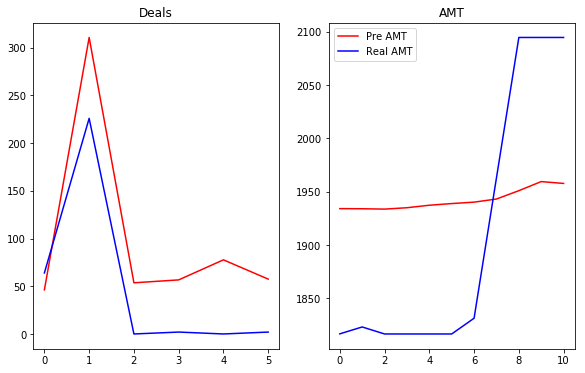

In [64]:
plt.figure(figsize=(15,6))
plt.subplot(131)
plt.title('Deals')
plt.plot(pred_test_deal, 'r', label='Pre Deal')
plt.plot(real_deal, 'b', label='Real Deal')
plt.subplot(132)
plt.title('AMT')
plt.plot(pred_test_amt, 'r', label='Pre AMT')
plt.plot(real_amt, 'b', label='Real AMT')
plt.legend(loc='best')